In [653]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings

In [654]:
from datasist.structdata import detect_outliers
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler , StandardScaler , RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , recall_score , precision_score , f1_score
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay , plot_roc_curve , plot_confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer , KNNImputer
from sklearn.model_selection import train_test_split , cross_validate
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from category_encoders import BinaryEncoder

In [655]:
warnings.filterwarnings('ignore')

In [656]:
%matplotlib inline

In [657]:
sns.set_theme(context = 'paper' , style = 'whitegrid' ,  rc = {'figure.figsize' : (8 , 4)})

In [658]:
df = pd.read_csv('Banking.csv' , na_values = ['?' , 'x?x' , '?|' , 'z||o'])
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,NaN,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,NaN,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,NaN,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,NaN,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,NaN,43,2,125510.82,1,1,1,79084.10,0


In [659]:
df.drop(['RowNumber' , 'CustomerId' , 'Surname'] , axis = 1 , inplace = True)

In [660]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  object 
 1   Geography        9944 non-null   object 
 2   Gender           9971 non-null   object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 859.5+ KB


In [661]:
df.duplicated().sum()

0

In [662]:
df.isnull().mean()

CreditScore        0.0000
Geography          0.0056
Gender             0.0029
Age                0.0000
Tenure             0.0000
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0000
IsActiveMember     0.0000
EstimatedSalary    0.0000
Exited             0.0000
dtype: float64

In [663]:
df['CreditScore'] = pd.to_numeric(df['CreditScore'] , errors = 'coerce')

In [664]:
df.isnull().mean()*100

CreditScore        0.36
Geography          0.56
Gender             0.29
Age                0.00
Tenure             0.00
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.00
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64

In [665]:
for col in df.select_dtypes('object').columns:
    display(df[col].value_counts().to_frame().T)

,France,Germany,Spain
Geography,4988,2490,2466


,Male,Female
Gender,5442,4529


<AxesSubplot:xlabel='Gender', ylabel='count'>

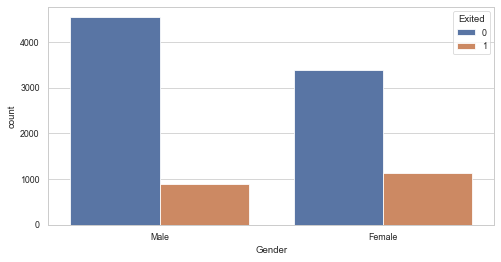

In [666]:
sns.countplot(df['Gender'] , hue = df['Exited'])

<AxesSubplot:xlabel='Geography', ylabel='count'>

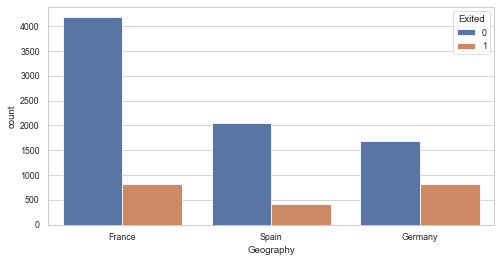

In [667]:
sns.countplot(df['Geography'] , hue = df['Exited'])

In [668]:
df.dtypes

CreditScore        float64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [669]:
df['Exited'].unique()

array([1, 0], dtype=int64)

<AxesSubplot:xlabel='Exited', ylabel='count'>

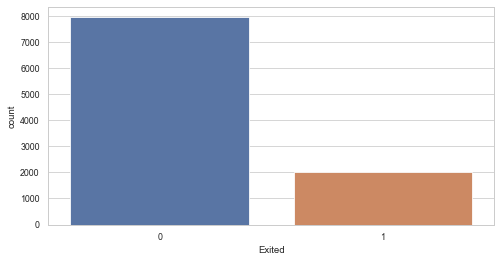

In [670]:
sns.countplot(df['Exited'])

In [671]:
for col in df.select_dtypes('number').columns:
    display(df[col].describe().to_frame().T)

,count,mean,std,min,25%,50%,75%,max
CreditScore,9964.0,650.447009,96.621969,350.0,584.0,652.0,717.0,850.0


,count,mean,std,min,25%,50%,75%,max
Age,10000.0,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0


,count,mean,std,min,25%,50%,75%,max
Tenure,10000.0,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0


,count,mean,std,min,25%,50%,75%,max
Balance,10000.0,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09


,count,mean,std,min,25%,50%,75%,max
NumOfProducts,10000.0,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0


,count,mean,std,min,25%,50%,75%,max
HasCrCard,10000.0,0.7055,0.45584,0.0,0.0,1.0,1.0,1.0


,count,mean,std,min,25%,50%,75%,max
IsActiveMember,10000.0,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0


,count,mean,std,min,25%,50%,75%,max
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


,count,mean,std,min,25%,50%,75%,max
Exited,10000.0,0.2037,0.402769,0.0,0.0,0.0,0.0,1.0


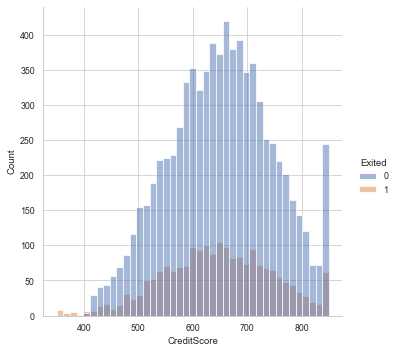

In [672]:
sns.displot(x = df['CreditScore'] , hue = df['Exited'])

<AxesSubplot:xlabel='CreditScore'>

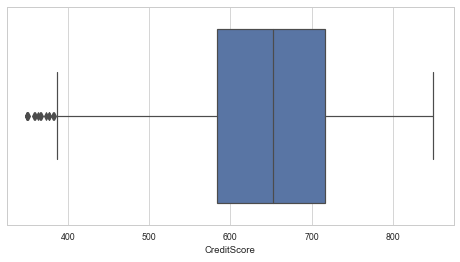

In [673]:
sns.boxplot(df['CreditScore'])

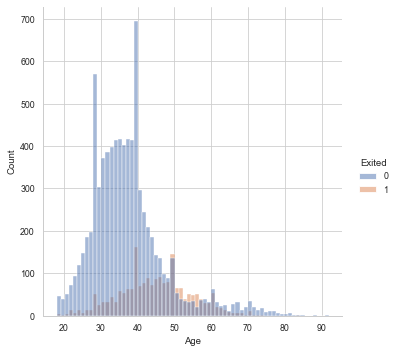

In [674]:
sns.displot(x = df['Age'] , hue = df['Exited'])

<AxesSubplot:xlabel='Age'>

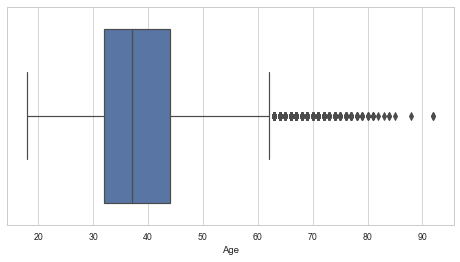

In [675]:
sns.boxplot(df['Age'])

In [676]:
df.drop(df[(df['Age'] < 20) | (df['Age'] > 80)].index , axis = 0 , inplace = True)

<AxesSubplot:xlabel='Tenure', ylabel='count'>

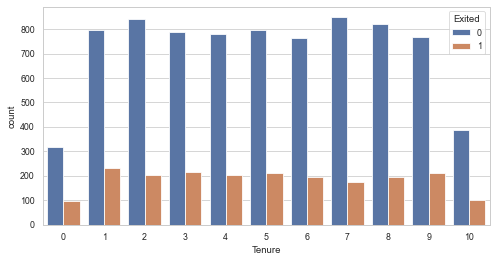

In [677]:
sns.countplot(df['Tenure'], hue = df['Exited'])

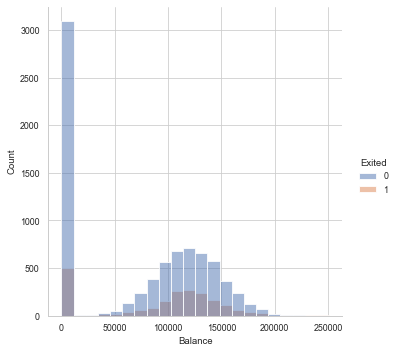

In [678]:
sns.displot(x = df['Balance'] , hue = df['Exited'])

<AxesSubplot:xlabel='Balance'>

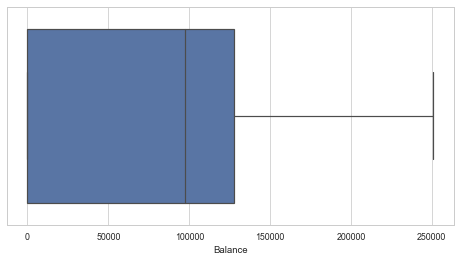

In [679]:
sns.boxplot(df['Balance'])

<AxesSubplot:xlabel='NumOfProducts', ylabel='count'>

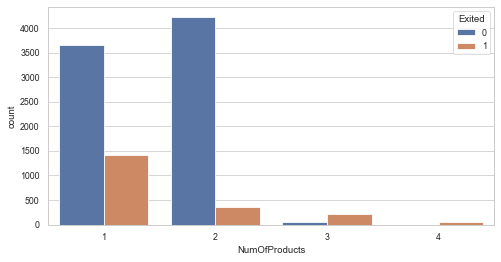

In [680]:
sns.countplot(df['NumOfProducts'] , hue = df['Exited'])

<AxesSubplot:xlabel='HasCrCard', ylabel='count'>

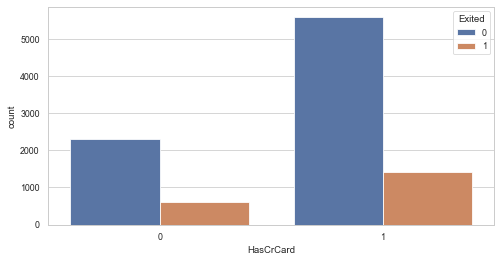

In [681]:
sns.countplot(df['HasCrCard'] , hue = df['Exited'])

<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

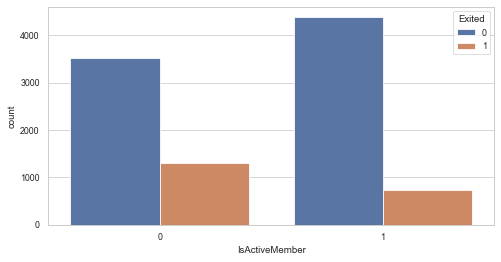

In [682]:
sns.countplot(df['IsActiveMember'] , hue = df['Exited'])

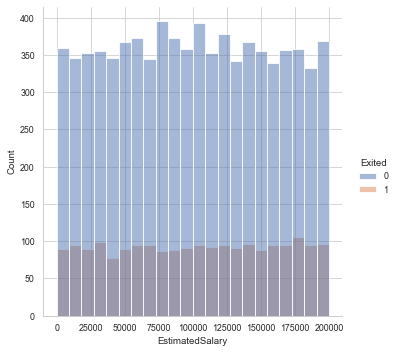

In [683]:
sns.displot(x = df['EstimatedSalary'] , hue = df['Exited'])

<AxesSubplot:xlabel='EstimatedSalary'>

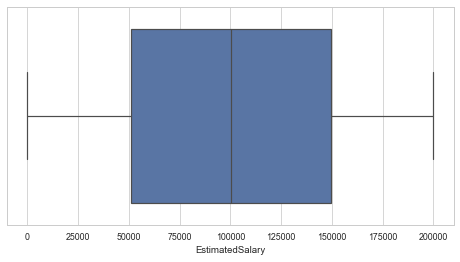

In [684]:
sns.boxplot(df['EstimatedSalary'])

<AxesSubplot:>

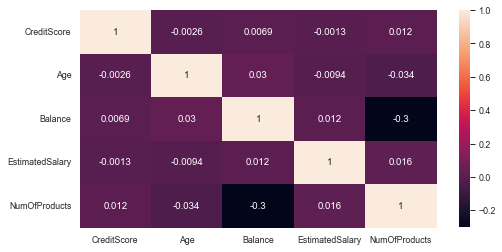

In [685]:
sns.heatmap(df[['CreditScore' , 'Age' , 'Balance' , 'EstimatedSalary' , 'NumOfProducts']].corr() , annot = True)

<AxesSubplot:xlabel='Age', ylabel='EstimatedSalary'>

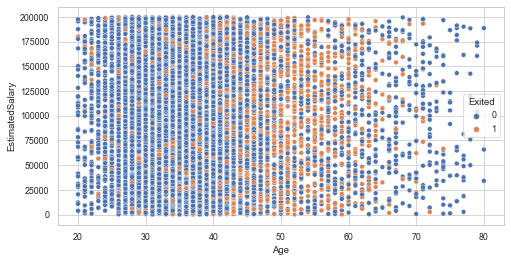

In [686]:
sns.scatterplot(data = df , x = df['Age'] , y = df['EstimatedSalary'] , hue = df['Exited'])

<AxesSubplot:xlabel='CreditScore', ylabel='Balance'>

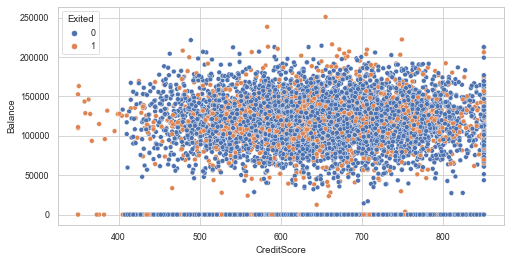

In [687]:
sns.scatterplot(data = df , x = df['CreditScore'] , y = df['Balance'] , hue = df['Exited'])

<AxesSubplot:xlabel='Age', ylabel='CreditScore'>

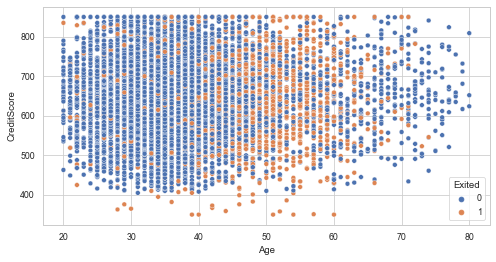

In [688]:
sns.scatterplot(data = df , x = df['Age'] , y = df['CreditScore'] , hue = df['Exited'])

In [689]:
df.isnull().mean()*100

CreditScore        0.362209
Geography          0.563437
Gender             0.291780
Age                0.000000
Tenure             0.000000
Balance            0.000000
NumOfProducts      0.000000
HasCrCard          0.000000
IsActiveMember     0.000000
EstimatedSalary    0.000000
Exited             0.000000
dtype: float64

In [690]:
df.dropna(subset = ['CreditScore' , 'Geography' , 'Gender'] , axis = 0 , inplace = True)

In [691]:
df.reset_index(inplace = True , drop = True)

In [692]:
ohe = OneHotEncoder(sparse = False , drop = 'first')

In [693]:
col = ['Geography' , 'Gender']
df = pd.concat([df , pd.DataFrame(ohe.fit_transform(df[col]) , 
                                  columns = ohe.get_feature_names_out())] , axis = 1)

In [694]:
df.drop(col , axis = 1 , inplace = True)

In [695]:
df.isnull().sum()

CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_Germany    0
Geography_Spain      0
Gender_Male          0
dtype: int64

In [696]:
x = df.drop(['Exited'] , axis = 1)
y = df['Exited']

In [697]:
smt = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

In [698]:
x , y = smt.fit_resample(x , y)

In [699]:
y.value_counts()

1    7819
0    6714
Name: Exited, dtype: int64

In [700]:
x_train , x_test , y_train , y_test = train_test_split(x , y , random_state = 7 , test_size = 0.2
                                                      ,shuffle = True , stratify = y)

In [701]:
y_train.value_counts()

1    6255
0    5371
Name: Exited, dtype: int64

In [702]:
y_test.value_counts()

1    1564
0    1343
Name: Exited, dtype: int64

In [703]:
sclr = StandardScaler()

In [704]:
x_train[x_train.columns] = sclr.fit_transform(x_train[x_train.columns])

In [705]:
x_test[x_test.columns] = sclr.transform(x_test[x_test.columns])

In [706]:
poly = PolynomialFeatures(degree = 3)

In [707]:
x_train = poly.fit_transform(x_train)
x_test = poly.transform(x_test)

In [708]:
model = LogisticRegression()

In [709]:
model.fit(x_train , y_train)

LogisticRegression()

In [710]:
y_train_prd = model.predict(x_train)

In [711]:
accuracy_score(y_true = y_train , y_pred = y_train_prd)

0.885429210390504

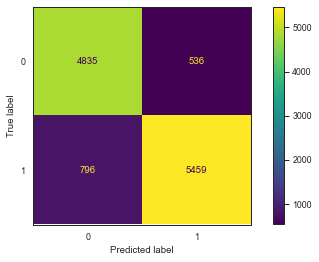

In [712]:
sns.set_style('white')
plot_confusion_matrix(model , x_train , y_train)

In [713]:
recall_score(y_true = y_train , y_pred = y_train_prd)

0.8727418065547562

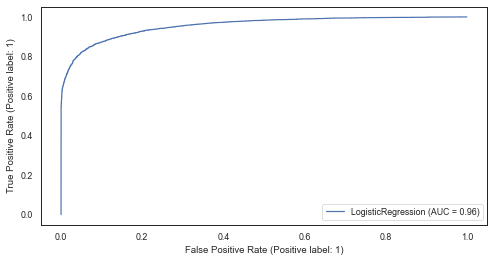

In [714]:
plot_roc_curve(model , x_train , y_train)

In [715]:
y_test_prd = model.predict(x_test)

In [716]:
accuracy_score(y_true = y_test , y_pred = y_test_prd)

0.8806329549363605

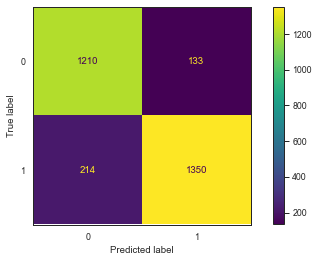

In [717]:
plot_confusion_matrix(model , x_test , y_test)

In [718]:
recall_score(y_true = y_test , y_pred = y_test_prd)

0.8631713554987213

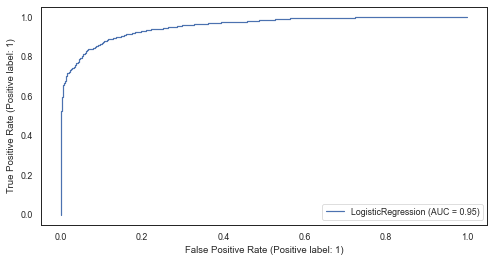

In [719]:
plot_roc_curve(model , x_test , y_test)